After getting the CIGALE outputs from Kim, I then do all of my analysis using this notebook. So this notebook will mainly revolve around converting the dust mass from CIGALE to a total gas mass, as well as using that alongside other CIGALE outputs and data within the VFS to conduct analysis and produce plots for the writeup.

As with the other files, I first import the necessary packages and set the file paths.

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
from astropy.table import Table
# Set up directories
os.environ['HOME'] = 'C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir + '/Herschel summary/cigale/out/'
from CIGALE_outputs import *

The purpose of this next code is to convert the CIGALE dust mass into total gas mass using the ratio from Sandstrom. It first converts the dust masses from kg to solar masses, alongside their uncertainties. And then, it converts all of these values into log space. Then, to get the gas mass, the program then calculates the gas mass in log space using the Dust-to-Gas Ratio, alongside its uncertainties, and outputs it as a csv file.

In [12]:
fits_file = tabledir + 'results.fits'
csv_file = 'testoutput.csv'  # Output CSV file
#First I convert the dust masses outputted by CIGALE into stellar mass, as well as calculate the gas mass from the DGR
# Solar mass in kg
solar_mass_kg = 1.98847e30

# DGR parameters in log space
log_DGR = -1.86
DGR_err = 0.22  # DGR uncertainty in dex

# Load the FITS file
with fits.open(fits_file) as hdul:
    data = hdul[1].data

# Convert dust masses to solar masses
bayes_dust_mass_solar = data['bayes.dust.mass'] / solar_mass_kg
best_dust_mass_solar = data['best.dust.mass'] / solar_mass_kg

# Convert uncertainties to solar masses in log space
bayes_dust_mass_err_solar = data['bayes.dust.mass_err'] / (data['bayes.dust.mass'] * np.log(10))  # Convert to log space

# Extract relevant columns
id_col = data['id']
log_bayes_dust_mass = np.log10(bayes_dust_mass_solar)
log_best_dust_mass = np.log10(best_dust_mass_solar)

# Calculate log gas masses and their uncertainties
log_bayes_gas_mass = log_bayes_dust_mass - log_DGR
log_bayes_gas_mass_err = np.sqrt(bayes_dust_mass_err_solar**2 + DGR_err**2)

log_best_gas_mass = log_best_dust_mass - log_DGR
log_best_gas_mass_err = DGR_err  # Best dust mass assumed to have no additional error

# Create a DataFrame to store results
df = pd.DataFrame({
    'id': id_col,
    'log(bayes.dust.mass)': log_bayes_dust_mass,
    'log(bayes.dust.mass.err)': bayes_dust_mass_err_solar,
    'log(best.dust.mass)': log_best_dust_mass,
    'log(bayes.gas.mass)': log_bayes_gas_mass,
    'log(bayes.gas.mass.err)': log_bayes_gas_mass_err,
    'log(best.gas.mass)': log_best_gas_mass,
    'log(best.gas.mass.err)': log_best_gas_mass_err,
    'bayes.sfh.sfr' : data['bayes.sfh.sfr'],
    'best.reduced_chi_square' : data['best.reduced_chi_square'],
})

# Export to CSV
df.to_csv(csv_file, index=False)
print(f"Data successfully written to {csv_file}")

Data successfully written to testoutput.csv


Once we have the CIGALE gas masses, we will also need something to compare it against. This is where the VFS' CO measurements comes in handy. This code takes in the HI measurements from the HI reference table, alongside its given HI to H2 ratio, converts it, and combine it to get the total gas mass.

In [10]:
#Calculate the H2 data from the HI reference table
# Load the CSV file
csv_file = 'test.csv'  # The table with HI measurements data
df = pd.read_csv(csv_file)

# Apply the function to calculate the new MH2 columns
df[['MH2', 'MH2_err_up', 'MH2_err_down']] = df.apply(lambda row: pd.Series(calculate_mh2(row)), axis=1)

# Convert all mass columns and errors to log10
mass_columns = ['MHI', 'MHI_err_up', 'MHI_err_down', 'MH2', 'MH2_err_up', 'MH2_err_down']
for col in mass_columns:
    df[col] = df[col].apply(lambda x: np.log10(x) if pd.notna(x) and x > 0 else np.nan)

df['Mgas'] = df.apply(
    lambda row: np.log10(10**row['MHI'] + 10**row['MH2']) 
    if pd.notna(row['MHI']) and pd.notna(row['MH2']) else np.nan,
    axis=1
)

# Save the modified DataFrame to a new CSV
output_csv = 'reference_gas_mass.csv'
df.to_csv(output_csv, index=False)

print(f"CSV file with MH2 and Mgas columns in log10 successfully written to {output_csv}")

CSV file with MH2 and Mgas columns in log10 successfully written to reference_gas_mass.csv


Once I have both of these tables, I can then perform analysis with it. This first code however, is a histogram of the dust luminosity from CIGALE. I did not convert the luminosity from the CIGALE's standard of Watts.

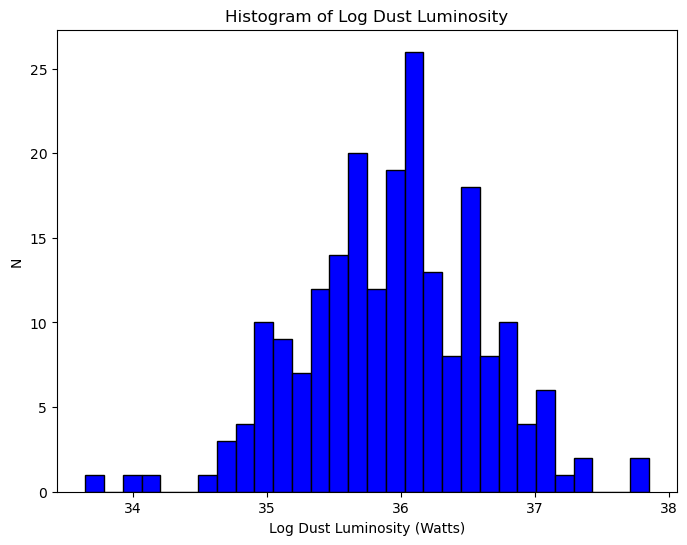

In [6]:
#plots the dust luminosity
fits_file = tabledir + 'results.fits'

# Load the FITS file and extract the dust luminosity data
with fits.open(fits_file) as hdul:
    data = hdul[1].data
    dust_luminosity = data['best.dust.luminosity']  # Extract dust luminosity column
    ids = data['id']  # Extract the id column

    # Convert dust luminosity to log space
    log_dust_luminosity = np.log10(dust_luminosity)

# Plot histogram of log dust luminosity
plt.figure(figsize=(8, 6))
plt.hist(log_dust_luminosity, bins=30, color='blue', edgecolor='black')
plt.xlabel('Log Dust Luminosity (Watts)')
plt.ylabel('N')
plt.title('Histogram of Log Dust Luminosity')

# Save and show the plot
#plt.savefig('dust_luminosity_histogram.png', dpi=300)
plt.show()

plt.show()

This is the code to plot Ha SFR vs the SFR from CIGALE to see whenever the two methods of calculaing the SFR agrees with each other.

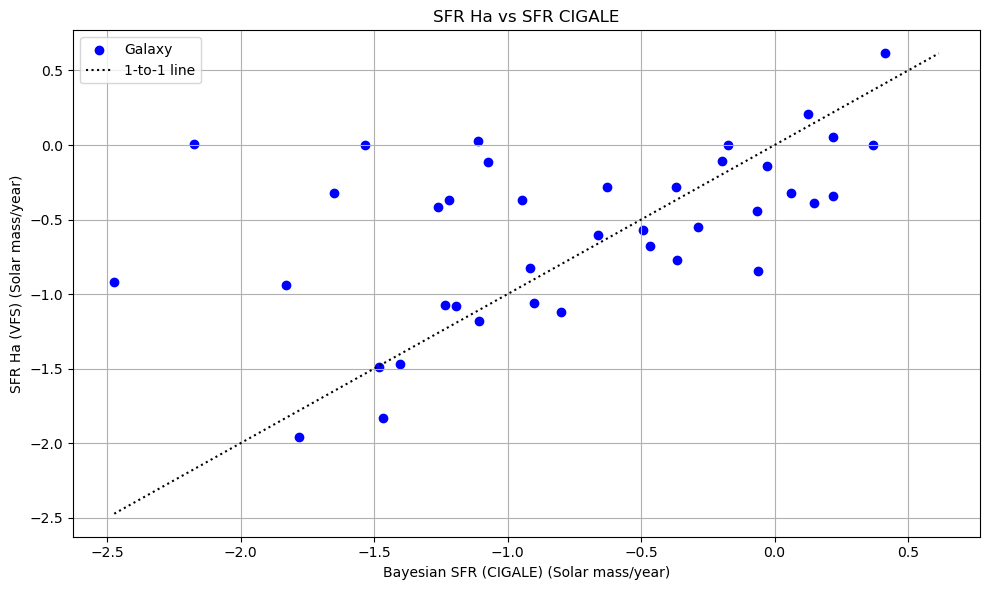

In [7]:
#plots the VFS Ha observation SFR vs CIGALE's
fits1 = tabledir + 'results.fits'
fits2 = tabledir + 'vf_v2_halpha.fits'

# Load both FITS tables as DataFrames
df1 = fits_to_dataframe(fits1, columns=['id', 'bayes.sfh.sfr', 'bayes.sfh.sfr_err'])
df2 = fits_to_dataframe(fits2, columns=['VFID', 'GAL_LOG_SFR_HA', 'GAL_LOG_SFR_HA_ERR', 'GAL_LOG_SFR_HA_FLAG'])

# Ensure data types match for the merge (e.g., converting IDs to strings if needed)
df1['id'] = df1['id'].astype(str)
df2['VFID'] = df2['VFID'].astype(str)

# Cross-match the tables using the first table's 'id' and the second table's 'VFID'
merged_df = pd.merge(df1, df2, left_on='id', right_on='VFID')

# Filter out rows where GAL_LOG_SFR_HA_FLAG is False
filtered_df = merged_df[merged_df['GAL_LOG_SFR_HA_FLAG'] == True]

# Convert bayes.sfh.sfr to log space (handling non-positive values)
filtered_df = filtered_df[filtered_df['bayes.sfh.sfr'] > 0]  # Remove non-positive values to avoid log errors
filtered_df['log_bayes_sfh_sfr'] = np.log10(filtered_df['bayes.sfh.sfr'])

# Check if there is valid data after filtering
if not filtered_df.empty:
    # Calculate the best-fit line using linear regression
    slope, intercept, _, _, _ = linregress(
        filtered_df['log_bayes_sfh_sfr'], filtered_df['GAL_LOG_SFR_HA']
    )

    # Scatter plot for log_bayes_sfh_sfr vs GAL_LOG_SFR_HA
    plt.figure(figsize=(10, 6))
    plt.scatter(
        filtered_df['log_bayes_sfh_sfr'], 
        filtered_df['GAL_LOG_SFR_HA'], 
        color='blue', 
        label='Galaxy'
    )
    

    # Plot the 1-to-1 line
    min_val = min(filtered_df['log_bayes_sfh_sfr'].min(), filtered_df['GAL_LOG_SFR_HA'].min())
    max_val = max(filtered_df['log_bayes_sfh_sfr'].max(), filtered_df['GAL_LOG_SFR_HA'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle=':', linewidth=1.5, label='1-to-1 line')

    # Set title and labels
    plt.title('SFR Ha vs SFR CIGALE')
    plt.xlabel('Bayesian SFR (CIGALE) (Solar mass/year)')
    plt.ylabel('SFR Ha (VFS) (Solar mass/year)')
    plt.grid(True)
    plt.legend()

    # Save and show the plot
    plt.tight_layout()
    #plt.savefig('sfr_bayes_comparison_plot.png', dpi=300)
    plt.show()

This code takes the difference between the CIGALE's outputted SFRs to see the affect Herschel data has on accurate CIGALE measurements. 

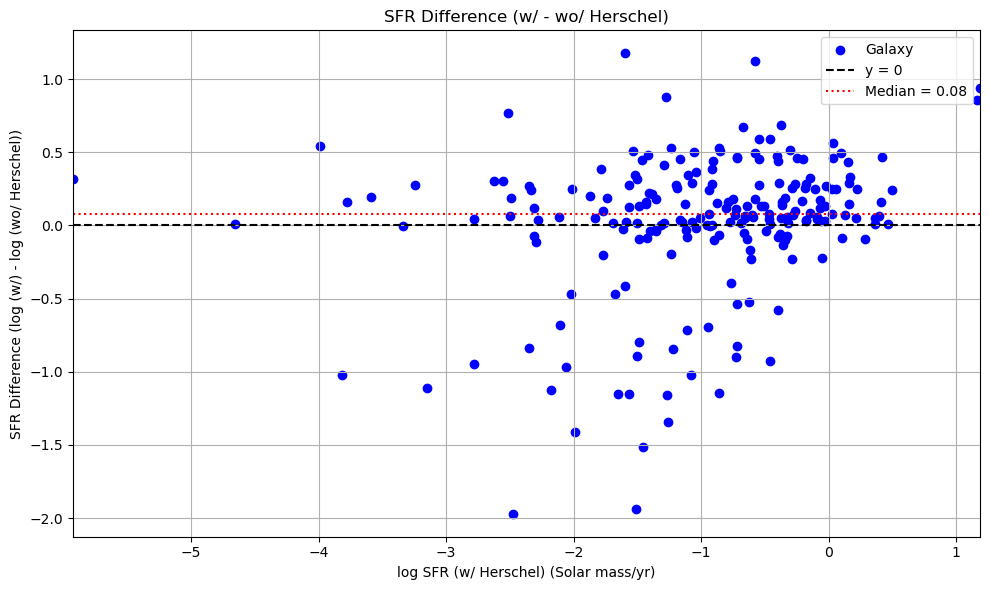

In [8]:
#Plot comparison of CIGALE results of the subset of galaxies, with and without Herschel data
fits1 = tabledir + 'results.fits'
fits2 = tabledir + 'resultsnoHerschel.fits'

# Load both FITS tables as DataFrames
columns_to_extract = ['id', 'bayes.sfh.sfr']
df1 = fits_to_dataframe(fits1, columns=columns_to_extract)
df2 = fits_to_dataframe(fits2, columns=columns_to_extract)

# Ensure data types match for the merge (e.g., converting IDs to strings if needed)
df1['id'] = df1['id'].astype(str)
df2['id'] = df2['id'].astype(str)

# Merge the tables by the 'id' column
merged_df = pd.merge(df1, df2, on='id', suffixes=('_fits1', '_fits2'))

# Filter out rows where SFR values are non-positive to avoid log errors
merged_df = merged_df[(merged_df['bayes.sfh.sfr_fits1'] > 0) & (merged_df['bayes.sfh.sfr_fits2'] > 0)]

# Convert SFR values to log10 space
merged_df['log_bayes_sfh_sfr_fits1'] = np.log10(merged_df['bayes.sfh.sfr_fits1'])
merged_df['log_bayes_sfh_sfr_diff'] = np.log10(merged_df['bayes.sfh.sfr_fits1']) - np.log10(merged_df['bayes.sfh.sfr_fits2'])

# Calculate the median of the plotted SFR difference values
median_diff = merged_df['log_bayes_sfh_sfr_diff'].median()

# Define plot limits for consistent scaling and plotting
x_min = merged_df['log_bayes_sfh_sfr_fits1'].min()
x_max = merged_df['log_bayes_sfh_sfr_fits1'].max()

# Plot SFR with Herschel vs. the difference in SFRs
plt.figure(figsize=(10, 6))
plt.scatter(
    merged_df['log_bayes_sfh_sfr_fits1'], 
    merged_df['log_bayes_sfh_sfr_diff'], 
    color='blue', 
    label='Galaxy'
)
plt.axhline(0, color='black', linestyle='--', label='y = 0')  # y=0 line for reference
plt.axhline(median_diff, color='red', linestyle=':', label=f'Median = {median_diff:.2f}')  # median line

# Set title and labels
plt.title('SFR Difference (w/ - wo/ Herschel)')
plt.xlabel('log SFR (w/ Herschel) (Solar mass/yr)')
plt.ylabel('SFR Difference (log (w/) - log (wo/ Herschel))')
plt.xlim(x_min, x_max)
plt.grid(True)
plt.legend()

# Save and show the plot
plt.tight_layout()
#plt.savefig('sfr_bayes_difference_plot.png', dpi=300)
plt.show()

The next code plots the VFS gas mass calculated earlier against the CIGALE gas mass converted using Sandstorm.

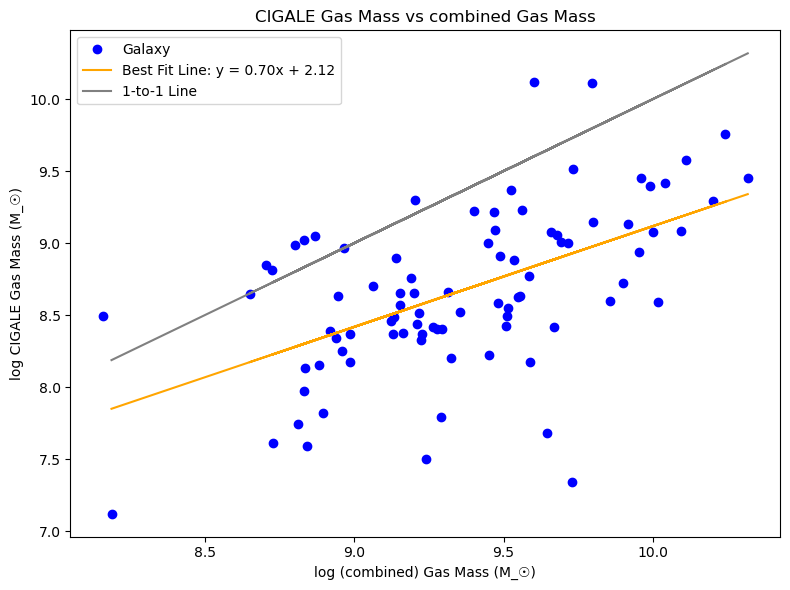

In [16]:
#Plots the VFS gas mass vs the CIGALE gas mass
# Load CSV files
first_csv_file = 'reference_gas_mass.csv'  # Replace with the actual path
df1 = pd.read_csv(first_csv_file)
second_csv_file = 'testoutput.csv'  # Replace with the actual path
df2 = pd.read_csv(second_csv_file)

# Merge the DataFrames on VFID and id
merged_df = pd.merge(df1, df2, left_on='VFID', right_on='id')

# Extract necessary columns for plotting
Mgas = merged_df['Mgas']  # Reference gas mass
bayes_gas_mass = merged_df['log(bayes.gas.mass)']  # Bayesian gas mass in log space

# Filter out non-zero and non-NaN values for best fit calculations
valid_mask = (Mgas > 0) & (bayes_gas_mass > 0) & (~np.isnan(Mgas)) & (~np.isnan(bayes_gas_mass))

# Perform linear regression for the Bayesian gas mass
slope_bayes, intercept_bayes, _, _, _ = linregress(Mgas[valid_mask], bayes_gas_mass[valid_mask])

# Plotting
plt.figure(figsize=(8, 6))

# Scatter plot of Mgas vs bayes_gas_mass
plt.plot(Mgas, bayes_gas_mass, 'o', color='blue', label='Galaxy')

# Plot best fit line
plt.plot(Mgas, slope_bayes * Mgas + intercept_bayes, color='orange', linestyle='-', label=f'Best Fit Line: y = {slope_bayes:.2f}x + {intercept_bayes:.2f}')

# Plot 1-to-1 line
plt.plot(Mgas, Mgas, color='gray', linestyle='-', label='1-to-1 Line')

# Label axes and add title
plt.xlabel('log (combined) Gas Mass (M_☉)')
plt.ylabel('log CIGALE Gas Mass (M_☉)')
plt.title('CIGALE Gas Mass vs combined Gas Mass')
plt.legend()

# Adjust layout, save, and display
plt.tight_layout()
#plt.savefig('bayes_gas_mass_plot.png', dpi=300, bbox_inches='tight')
plt.show()

Next, we will need to calculate the depletion time scales by using the respective gas masses and SFRs. For this current example I used the gas mass from the VFS, and SFR from CIGALE AND VFS.

In [2]:
csv_file = 'testoutput.csv'  # CSV containing bayes.gas.mass
fits_file = tabledir + 'vf_v2_halpha.fits'
mgas_csv_file = 'reference_gas_mass.csv'  # CSV containing 'Mgas'
# Calculate the depletion time tables from the various tables
# Load CSV file as DataFrame
df1 = pd.read_csv(csv_file, usecols=['id', 'log(bayes.gas.mass)', 'bayes.sfh.sfr'])

# Convert log(bayes.gas.mass) to normal space
df1['bayes.gas.mass'] = 10 ** df1['log(bayes.gas.mass)']

# Load FITS table as DataFrame
df2 = fits_to_dataframe(fits_file, columns=['VFID', 'GAL_LOG_SFR_HA', 'GAL_LOG_SFR_HA_ERR', 'GAL_LOG_SFR_HA_FLAG'])

# Load additional CSV file with Mgas
df3 = pd.read_csv(mgas_csv_file, usecols=['VFID', 'Mgas'])

# Ensure data types match for merging
df1['id'] = df1['id'].astype(str)
df2['VFID'] = df2['VFID'].astype(str)
df3['VFID'] = df3['VFID'].astype(str)

# Merge df1 and df2 using 'id' and 'VFID'
merged_df = pd.merge(df1, df2, left_on='id', right_on='VFID')

# Merge with df3 to include 'Mgas'
merged_df = pd.merge(merged_df, df3, on='VFID', how='left')

# Filter out rows where GAL_LOG_SFR_HA_FLAG is False
filtered_df = merged_df[merged_df['GAL_LOG_SFR_HA_FLAG'] == True]

# Convert SFR values from log space to normal space
filtered_df['SFR1'] = 10 ** filtered_df['GAL_LOG_SFR_HA']
filtered_df['SFR2'] = 10 ** filtered_df['bayes.sfh.sfr']

# Ensure valid data for calculation: bayes.gas.mass > 0 and SFR > 0
filtered_df = filtered_df[(filtered_df['Mgas'] > 0) & (filtered_df['SFR1'] > 0)]

# Calculate depletion time using SFR1
filtered_df['t_dep1(CO)'] = 10**(filtered_df['Mgas']) / filtered_df['SFR1']

# Ensure valid data for calculation: bayes.gas.mass > 0 and SFR2 > 0
filtered_df = filtered_df[(filtered_df['Mgas'] > 0) & (filtered_df['SFR2'] > 0)]

# Calculate depletion time using SFR2
filtered_df['t_dep2(CIGALE)'] = 10**filtered_df['Mgas'] / filtered_df['SFR2']

# Save to CSV with the selected parameters including 'Mgas'
output_csv = 'depletion_time_table.csv'
filtered_df[['id', 'bayes.gas.mass', 'GAL_LOG_SFR_HA', 't_dep1(CO)', 'bayes.sfh.sfr', 't_dep2(CIGALE)', 'Mgas']].to_csv(output_csv, index=False)

print(f"Depletion time table saved to {output_csv}")

Depletion time table saved to depletion_time_table.csv


C:\Users\USER\AppData\Local\Temp\ipykernel_1572\3793568235.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['SFR1'] = 10 ** filtered_df['GAL_LOG_SFR_HA']
C:\Users\USER\AppData\Local\Temp\ipykernel_1572\3793568235.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['SFR2'] = 10 ** filtered_df['bayes.sfh.sfr']


The next code plots out the respective calculated depletion times.

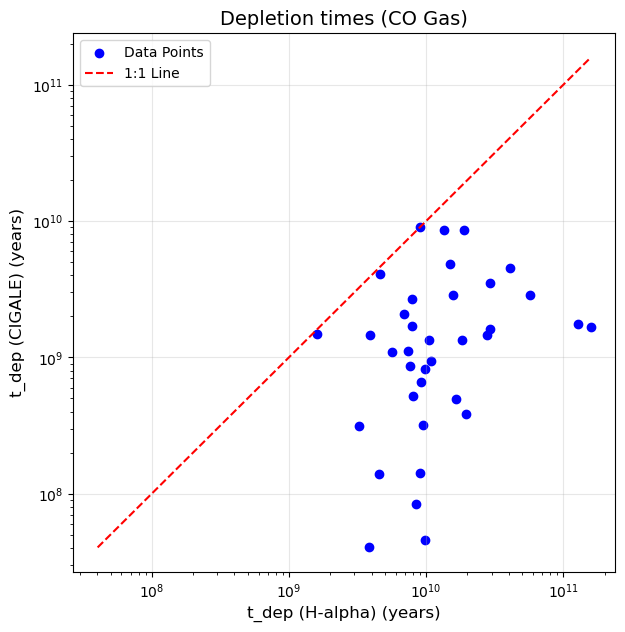

In [3]:
#Plot the depletion times against each other
# Load the CSV file
csv_file = 'depletion_time_table.csv'
df = pd.read_csv(csv_file)

# Create the plot
plt.figure(figsize=(7, 7))
plt.scatter(df['t_dep1(CO)'], df['t_dep2(CIGALE)'], color='blue', alpha=1, label='Data Points')

# Add a 1-to-1 line (y = x)
min_val = min(df['t_dep1(CO)'].min(), df['t_dep2(CIGALE)'].min())  # Get min value for limits
max_val = max(df['t_dep1(CO)'].max(), df['t_dep2(CIGALE)'].max())  # Get max value for limits
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='1:1 Line')

# Labels and formatting
plt.xlabel('t_dep (H-alpha) (years)', fontsize=12)
plt.ylabel('t_dep (CIGALE) (years)', fontsize=12)
plt.title('Depletion times (CO Gas)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.xscale('log')  # Optional: Log scale if values vary widely
plt.yscale('log')  # Optional: Log scale

# Save and show the plot
#plt.savefig('t_dep1_vs_t_dep2 (CO Gas).png', dpi=300)
plt.show()

Another angle to analyze thing is trying to find the aperture corrections of these Herschel galaxies using the tables from Virgo Filaments I. And so I extracted tables 3 and 4 from the archive, grabbed only the necessary data, merge both together, and take the f_ap from the CO transistion level of 1 -> 0 as the basis aperture correction.

In [5]:
#Get the aptureture corrections from the 2 tables of Dr. Gianluca's paper, as well as take only the CO transition from 0 to 1
#Load the CSV files
csv1 = 'table3.csv' 
csv2 = 'table4.csv'  
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)

# Rename columns to have a common name for merging
if 'CO_trans' in df1.columns:
    df1.rename(columns={'CO_trans': 'CO'}, inplace=True)
if 'COtrans' in df2.columns:
    df2.rename(columns={'COtrans': 'CO'}, inplace=True)

# Add a column to indicate source file
df1['Source'] = 'table3'
df2['Source'] = 'table4'

# Select only the relevant columns
df1_selected = df1[['Galaxy', 'fap', 'CO', 'Source', 'log(MH2)']]
df2_selected = df2[['Galaxy', 'fap', 'CO', 'Source', 'log(MH2)']]

# Concatenate the two datasets
merged_df = pd.concat([df1_selected, df2_selected])

# Save the full merged file
merged_csv = 'merged_f_ap_table.csv'
merged_df.to_csv(merged_csv, index=False)

# Filter only rows where CO == "1→0"
filtered_df = merged_df[merged_df['CO'] == "1-->0"]

# Save the filtered file
filtered_csv = 'filtered_f_ap.csv'
filtered_df.to_csv(filtered_csv, index=False)

print(f"Merged data saved to {merged_csv}")
print(f"Filtered data (CO = '1→0') saved to {filtered_csv}")

Merged data saved to merged_f_ap_table.csv
Filtered data (CO = '1→0') saved to filtered_f_ap.csv


From that table, I then filter out only Herschel galaxies in order to conduct analysis on them.

In [6]:
#Filter the table to only get the results for Herschel galaxies
# Input file paths
csv_file1 = "filtered_f_ap.csv"  # File with Galaxy, CO, and log(MH2)
csv_file2 = "Photometrytesting2.csv"  # File with VF_IDs

# Load CSV files
csv_df1 = pd.read_csv(csv_file1)
csv_df2 = pd.read_csv(csv_file2)

# Ensure 'Galaxy' and 'GALAXY' columns are in a consistent format
csv_df1['Galaxy'] = csv_df1['Galaxy'].astype(str).str.strip()
csv_df2['GALAXY'] = csv_df2['GALAXY'].astype(str).str.strip()

# Format VF_ID properly
csv_df2['VFID'] = csv_df2['VF_ID'].apply(lambda x: f"VFID{int(x):04d}" if pd.notna(x) else None)

# Create a list to store matched rows
matched_rows = []

# Loop through each row in csv_df2 to find matching galaxies
for index, row in csv_df2.iterrows():
    galaxy = row['GALAXY']
    vfid = row['VFID']
    
    # Find rows in csv_df1 matching the galaxy name
    galaxy_matches = csv_df1[csv_df1['Galaxy'] == galaxy]
    
    if not galaxy_matches.empty:
        # Prioritize rows where CO == "1-->0"
        co_rows = galaxy_matches[galaxy_matches['CO'] == "1-->0"]
        
        # Select the appropriate row (prefer "1-->0" match, otherwise take any match)
        selected_row = co_rows.iloc[0] if not co_rows.empty else galaxy_matches.iloc[0]
        
        # Extract log(MH2) from csv_df1
        log_mh2 = selected_row['log(MH2)'] if 'log(MH2)' in selected_row else None
        
        # Append selected row as a dictionary (to ensure correct merging)
        selected_dict = selected_row.to_dict()
        selected_dict['VFID'] = vfid  # Add VFID column
        selected_dict['log(MH2)'] = log_mh2  # Ensure log(MH2) is included
        matched_rows.append(selected_dict)

# Convert list of matched rows into a DataFrame
filtered_csv_df = pd.DataFrame(matched_rows)

# Save the filtered data
output_csv_file = "filtered_asu.csv"
filtered_csv_df.to_csv(output_csv_file, index=False)

print(f"Filtered data saved as {output_csv_file}.")

Filtered data saved as filtered_asu.csv.


This is the code that plots the ratio of the respective gas masses. This time colored by the aperture correction ratio extracted from earlier.

VFIDs with log(Bayes Gas Mass / Reference Gas Mass) below -2:
VFID2068


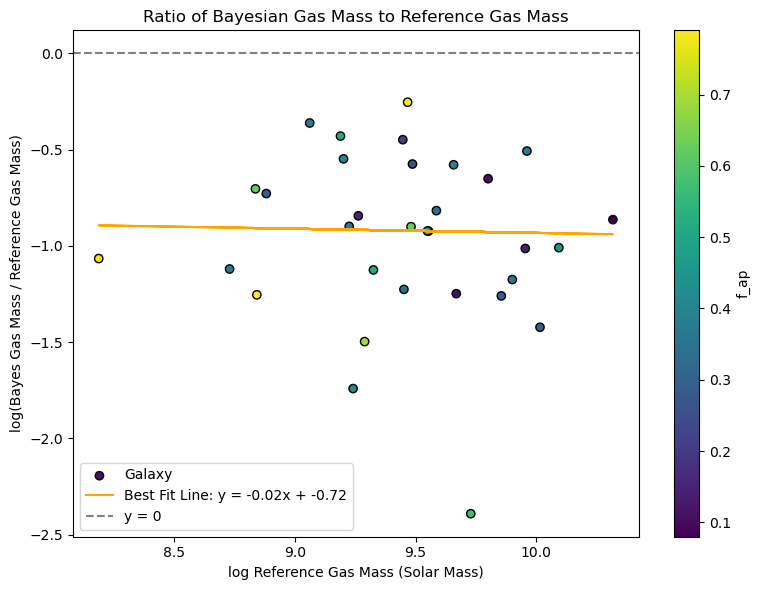

In [8]:
#Plots the ratio of the gas masses color-coded by the aperture corrections
# Input CSV files
first_csv_file = 'reference_gas_mass.csv'  # Path to the first CSV file
second_csv_file = 'testoutput.csv'  # Path to the second CSV file
third_csv_file = 'filtered_asu.csv'  # Path to the third CSV file (filtered_asu)

# Load the CSV files
df1 = pd.read_csv(first_csv_file)
df2 = pd.read_csv(second_csv_file)
filtered_asu_df = pd.read_csv(third_csv_file)

# Merge the DataFrames on VFID and id
merged_df = pd.merge(df1, df2, left_on='VFID', right_on='id')

# Extract necessary columns for calculations
Mgas = merged_df['Mgas']  # Reference gas mass
bayes_gas_mass = merged_df['log(bayes.gas.mass)']  # Bayesian gas mass in log space

# Filter out invalid entries
valid_mask = (Mgas > 0) & (~np.isnan(Mgas)) & (~np.isnan(bayes_gas_mass))

# Calculate log(Bayes Gas Mass / Reference Gas Mass)
log_reference_gas_mass = Mgas[valid_mask]
log_mass_ratio = bayes_gas_mass[valid_mask] - log_reference_gas_mass

# Merge with the third CSV file to filter based on VFID
filtered_vfids = filtered_asu_df['VFID']  # Assuming 'VFID' column exists in filtered_asu.csv
merged_filtered_df = merged_df[merged_df['VFID'].isin(filtered_vfids)]

# Apply the mask to the filtered data
filtered_log_reference_gas_mass = log_reference_gas_mass[merged_df['VFID'].isin(filtered_vfids)]
filtered_log_mass_ratio = log_mass_ratio[merged_df['VFID'].isin(filtered_vfids)]
filtered_fap_values = filtered_asu_df.loc[filtered_asu_df['VFID'].isin(filtered_vfids), 'fap']  # Assuming 'fap' column exists

# Identify points where log_mass_ratio < -2 and print their VFIDs
outlier_mask = filtered_log_mass_ratio < -2
outlier_vfids = merged_filtered_df.loc[outlier_mask, 'VFID']

if not outlier_vfids.empty:
    print("VFIDs with log(Bayes Gas Mass / Reference Gas Mass) below -2:")
    print(outlier_vfids.to_string(index=False))
else:
    print("No VFIDs found with log_mass_ratio below -2.")

# Perform linear regression
slope, intercept, _, _, _ = linregress(filtered_log_reference_gas_mass, filtered_log_mass_ratio)

# Plotting
plt.figure(figsize=(8, 6))

# Plot log(Bayes Gas Mass / Reference Gas Mass) vs log(Reference Gas Mass) with color-coding by fap
scatter = plt.scatter(filtered_log_reference_gas_mass, filtered_log_mass_ratio, c=filtered_fap_values, cmap='viridis', label='Galaxy', edgecolors='k')

# Plot the best fit line
plt.plot(
    filtered_log_reference_gas_mass, 
    slope * filtered_log_reference_gas_mass + intercept, 
    color='orange', 
    linestyle='-', 
    label=f'Best Fit Line: y = {slope:.2f}x + {intercept:.2f}'
)

# Add a color bar for the fap values
plt.colorbar(scatter, label='f_ap')

# Add a horizontal line at y=0 for reference
plt.axhline(0, color='gray', linestyle='--', label='y = 0')

# Label axes and title
plt.xlabel('log Reference Gas Mass (Solar Mass)')
plt.ylabel('log(Bayes Gas Mass / Reference Gas Mass)')
plt.title('Ratio of Bayesian Gas Mass to Reference Gas Mass')
plt.legend()

# Adjust layout, save, and display
plt.tight_layout()
#plt.savefig('bayes_mass_ratio_vs_reference_mass_f_ap.png', dpi=300, bbox_inches='tight')
plt.show()